In [1]:
import numpy as np
import scipy.io as scio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import seaborn as sns
import cartopy
import matplotlib
from cartopy.util import add_cyclic_point


def reduced_dimension(variable_2D_lon_lat,times=4):
    signal_divide_noise1_reduced = variable_2D_lon_lat.copy()
    for i in range(360):
        for j in range(180):
            if i % times != 0 or j % times != 0:
                signal_divide_noise1_reduced[i, j] = np.nan
    return signal_divide_noise1_reduced

def central_transform(data2D):
    data2D_new=np.full((360,180),np.nan)
    data2D_new[180:361,:]=data2D[20:200,:]
    data2D_new[0:160,:]=data2D[200:360,:]
    data2D_new[160:180,:]=data2D[0:20,:]
    return data2D_new


C:\Users\dell\.conda\envs\myenv2\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
data=scio.loadmat('./Input_data/ToE_temperature_data_level.mat')
lon=data['lon'][:]
lat=data['lat'][:]
ToE_warming=data['ToE_warming'][:]
ToE_warming_surface=ToE_warming[:,:,0]
ToE_warming_surface[:,0:20]=np.nan  #mask the poloar regions
ToE_warming_surface[:,158:180]=np.nan

data=scio.loadmat('./Input_data/ToE_salinity_data_level.mat')
ToE_salinification=data['ToE_salting'][:]
ToE_salinification_surface=ToE_salinification[:,:,1]
ToE_freshening=data['ToE_freshing'][:]
ToE_freshening_surface=ToE_freshening[:,:,1]
ToE_salinification_surface[:,0:20]=np.nan
ToE_salinification_surface[:,158:180]=np.nan
ToE_freshening_surface[:,0:20]=np.nan
ToE_freshening_surface[:,158:180]=np.nan

data=scio.loadmat('./Input_data/ToE_pH_surface.mat')
ToE_acidification_surface=data['ToE_acidification'][:]
ToE_acidification_surface[:,0:20]=np.nan
ToE_acidification_surface[:,158:180]=np.nan


In [3]:
#### load significant point flag
data=scio.loadmat('./Input_data/ToE_doubletriple_significant_flag_surface.mat')
ToE_warming_freshening_significant_flag=data['ToE_warming_freshening_significant_flag'][:]
ToE_warming_salinification_significant_flag=data['ToE_warming_salinification_significant_flag'][:]
ToE_warming_freshening_significant_flag[:,0:20]=np.nan
ToE_warming_freshening_significant_flag[:,158:180]=np.nan
ToE_warming_salinification_significant_flag[:,0:20]=np.nan
ToE_warming_salinification_significant_flag[:,158:180]=np.nan

# load single compound CID significant flag
data=scio.loadmat('./Input_data/ToE_temperautre_significant_flag_level.mat')
ToE_NOT_significant_level=data['ToE_NOT_significant_level'][:] #1: not significant  0:significant
ToE_temperature_significant_level=np.copy(ToE_NOT_significant_level)
ToE_temperature_significant_level[ToE_temperature_significant_level==1]=2
ToE_temperature_significant_level[ToE_temperature_significant_level==0]=1
ToE_temperature_significant_level[ToE_temperature_significant_level==2]=0 #1: significant 0:not significant
ToE_temperature_significant_surface=ToE_temperature_significant_level[:,:,0]
del ToE_NOT_significant_level

data=scio.loadmat('./Input_data/ToE_salinity_significant_flag_level.mat')
ToE_NOT_significant_level=data['ToE_NOT_significant_level'][:] #1: not significant  0:significant
ToE_salinity_significant_level=np.copy(ToE_NOT_significant_level)
ToE_salinity_significant_level[ToE_salinity_significant_level==1]=2
ToE_salinity_significant_level[ToE_salinity_significant_level==0]=1
ToE_salinity_significant_level[ToE_salinity_significant_level==2]=0 #1: significant 0:not significant
ToE_salinity_significant_surface=ToE_salinity_significant_level[:,:,0]
del ToE_NOT_significant_level

ToE_temperature_significant_surface[:,0:20]=np.nan #mask the poloar regions
ToE_temperature_significant_surface[:,158:180]=np.nan
ToE_salinity_significant_surface[:,0:20]=np.nan
ToE_salinity_significant_surface[:,158:180]=np.nan

In [4]:
####### find T+S+DO overlap grid
# warming+salinization+deoxygenation
index=np.isnan(ToE_warming_surface)
isOverlap_warming_salinification=np.logical_and(~np.isnan(ToE_warming_surface),~np.isnan(ToE_salinification_surface))
isOverlap_warming_freshening=np.logical_and(~np.isnan(ToE_warming_surface),~np.isnan(ToE_freshening_surface))

TOE_overlap_warming_salinification=np.full((360,180),np.nan)
TOE_overlap_warming_freshening=np.full((360,180),np.nan)
for i in range(360):
    for j in range(180):
        if(isOverlap_warming_salinification[i,j]):
            TOE_overlap_warming_salinification[i,j]=np.nanmax([ToE_warming_surface[i,j],ToE_salinification_surface[i,j]])
        if(isOverlap_warming_freshening[i,j]):
            TOE_overlap_warming_freshening[i,j]=np.nanmax([ToE_warming_surface[i,j],ToE_freshening_surface[i,j]])


# find only warming
isOverlap=np.logical_or.reduce((~np.isnan(TOE_overlap_warming_salinification),~np.isnan(TOE_overlap_warming_freshening)))
ToE_onlyWarming=ToE_warming_surface
ToE_onlyWarming[isOverlap]=np.nan
ToE_temperature_significant_surface[np.isnan(ToE_onlyWarming)]=np.nan  #only keep the 'only warming' significant point
ToE_onlyWarming_significant_surface=np.copy(ToE_temperature_significant_surface)

# find only salinification
ToE_onlySalin_significant_surface=np.copy(ToE_salinity_significant_surface)
isOverlap=~np.isnan(TOE_overlap_warming_salinification)
ToE_onlySalin=ToE_salinification_surface
ToE_onlySalin[isOverlap]=np.nan
ToE_onlySalin_significant_surface[np.isnan(ToE_onlySalin)]=np.nan  #only keep the 'only deoxygenation' significant point

# find only freshening
ToE_onlyFresh_significant_surface=np.copy(ToE_salinity_significant_surface)
isOverlap=~np.isnan(TOE_overlap_warming_freshening)
ToE_onlyFresh=ToE_freshening_surface
ToE_onlyFresh[isOverlap]=np.nan
ToE_onlyFresh_significant_surface[np.isnan(ToE_onlyFresh)]=np.nan  #only keep the 'only freshening' significant point


#### transform the data projection central longitude
TOE_overlap_warming_salinification=central_transform(TOE_overlap_warming_salinification)
TOE_overlap_warming_freshening=central_transform(TOE_overlap_warming_freshening)
ToE_onlyWarming=central_transform(ToE_onlyWarming)
ToE_onlySalin=central_transform(ToE_onlySalin)
ToE_onlyFresh=central_transform(ToE_onlyFresh)
ToE_acidification_surface=central_transform(ToE_acidification_surface)

#### transform the data projection central longitude for insigifnicant flags
ToE_onlyWarming_significant_surface=central_transform(ToE_onlyWarming_significant_surface)
ToE_onlySalin_significant_surface=central_transform(ToE_onlySalin_significant_surface)
ToE_onlyFresh_significant_surface=central_transform(ToE_onlyFresh_significant_surface)
ToE_warming_freshening_significant_flag=central_transform(ToE_warming_freshening_significant_flag)
ToE_warming_salinification_significant_flag=central_transform(ToE_warming_salinification_significant_flag)


TOE_overlap_warming_salinification, cycle_lon = add_cyclic_point(np.transpose(TOE_overlap_warming_salinification),np.transpose(lon)[0])
TOE_overlap_warming_freshening, cycle_lon = add_cyclic_point(np.transpose(TOE_overlap_warming_freshening),np.transpose(lon)[0])
ToE_onlyWarming, cycle_lon = add_cyclic_point(np.transpose(ToE_onlyWarming),np.transpose(lon)[0])
ToE_acidification_surface, cycle_lon = add_cyclic_point(np.transpose(ToE_acidification_surface),np.transpose(lon)[0])
ToE_onlySalin, cycle_lon = add_cyclic_point(np.transpose(ToE_onlySalin),np.transpose(lon)[0])
ToE_onlyFresh, cycle_lon = add_cyclic_point(np.transpose(ToE_onlyFresh),np.transpose(lon)[0])



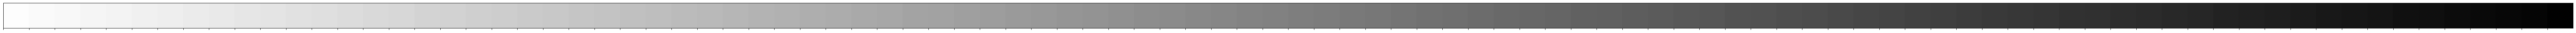

In [5]:
######### create customize colorbars
blues=sns.color_palette('Blues_r',6)
blues=[blues[2],blues[4]]
new_blues=matplotlib.colors.ListedColormap(blues,name='new_blues')

# sns.palplot(sns.color_palette('Reds_r',6))
reds=sns.color_palette('Reds_r',6)
reds=[reds[2],reds[4]]
new_reds=matplotlib.colors.ListedColormap(reds,name='new_reds')

# sns.palplot(sns.color_palette('RdPu_r',6))
pruples=sns.color_palette('BuGn_r',6)
pruples=[pruples[2],pruples[4]]
new_greens=matplotlib.colors.ListedColormap(pruples,name='new_greens')

# sns.palplot(sns.color_palette('binary',100))
whites=sns.color_palette('binary',100)
whites=[whites[0],whites[0]]
new_whites=matplotlib.colors.ListedColormap(whites,name='new_whites')

# sns.palplot(sns.color_palette('pink',20))
pinks=sns.color_palette('pink',20)
pinks=[pinks[6],pinks[10]]  
new_pinks=matplotlib.colors.ListedColormap(pinks,name='new_pinks')  #### only salinification
# sns.palplot(pinks)

# sns.palplot(sns.color_palette('bone',13))
bones=sns.color_palette('bone',13)
bones=[bones[7],bones[12]]  
new_bones=matplotlib.colors.ListedColormap(bones,name='new_bones')  #### only freshening
# sns.palplot(bones)

C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)
C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contourf(*args, **kwargs)
C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
C:\Users\dell\.conda\envs\myenv2\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


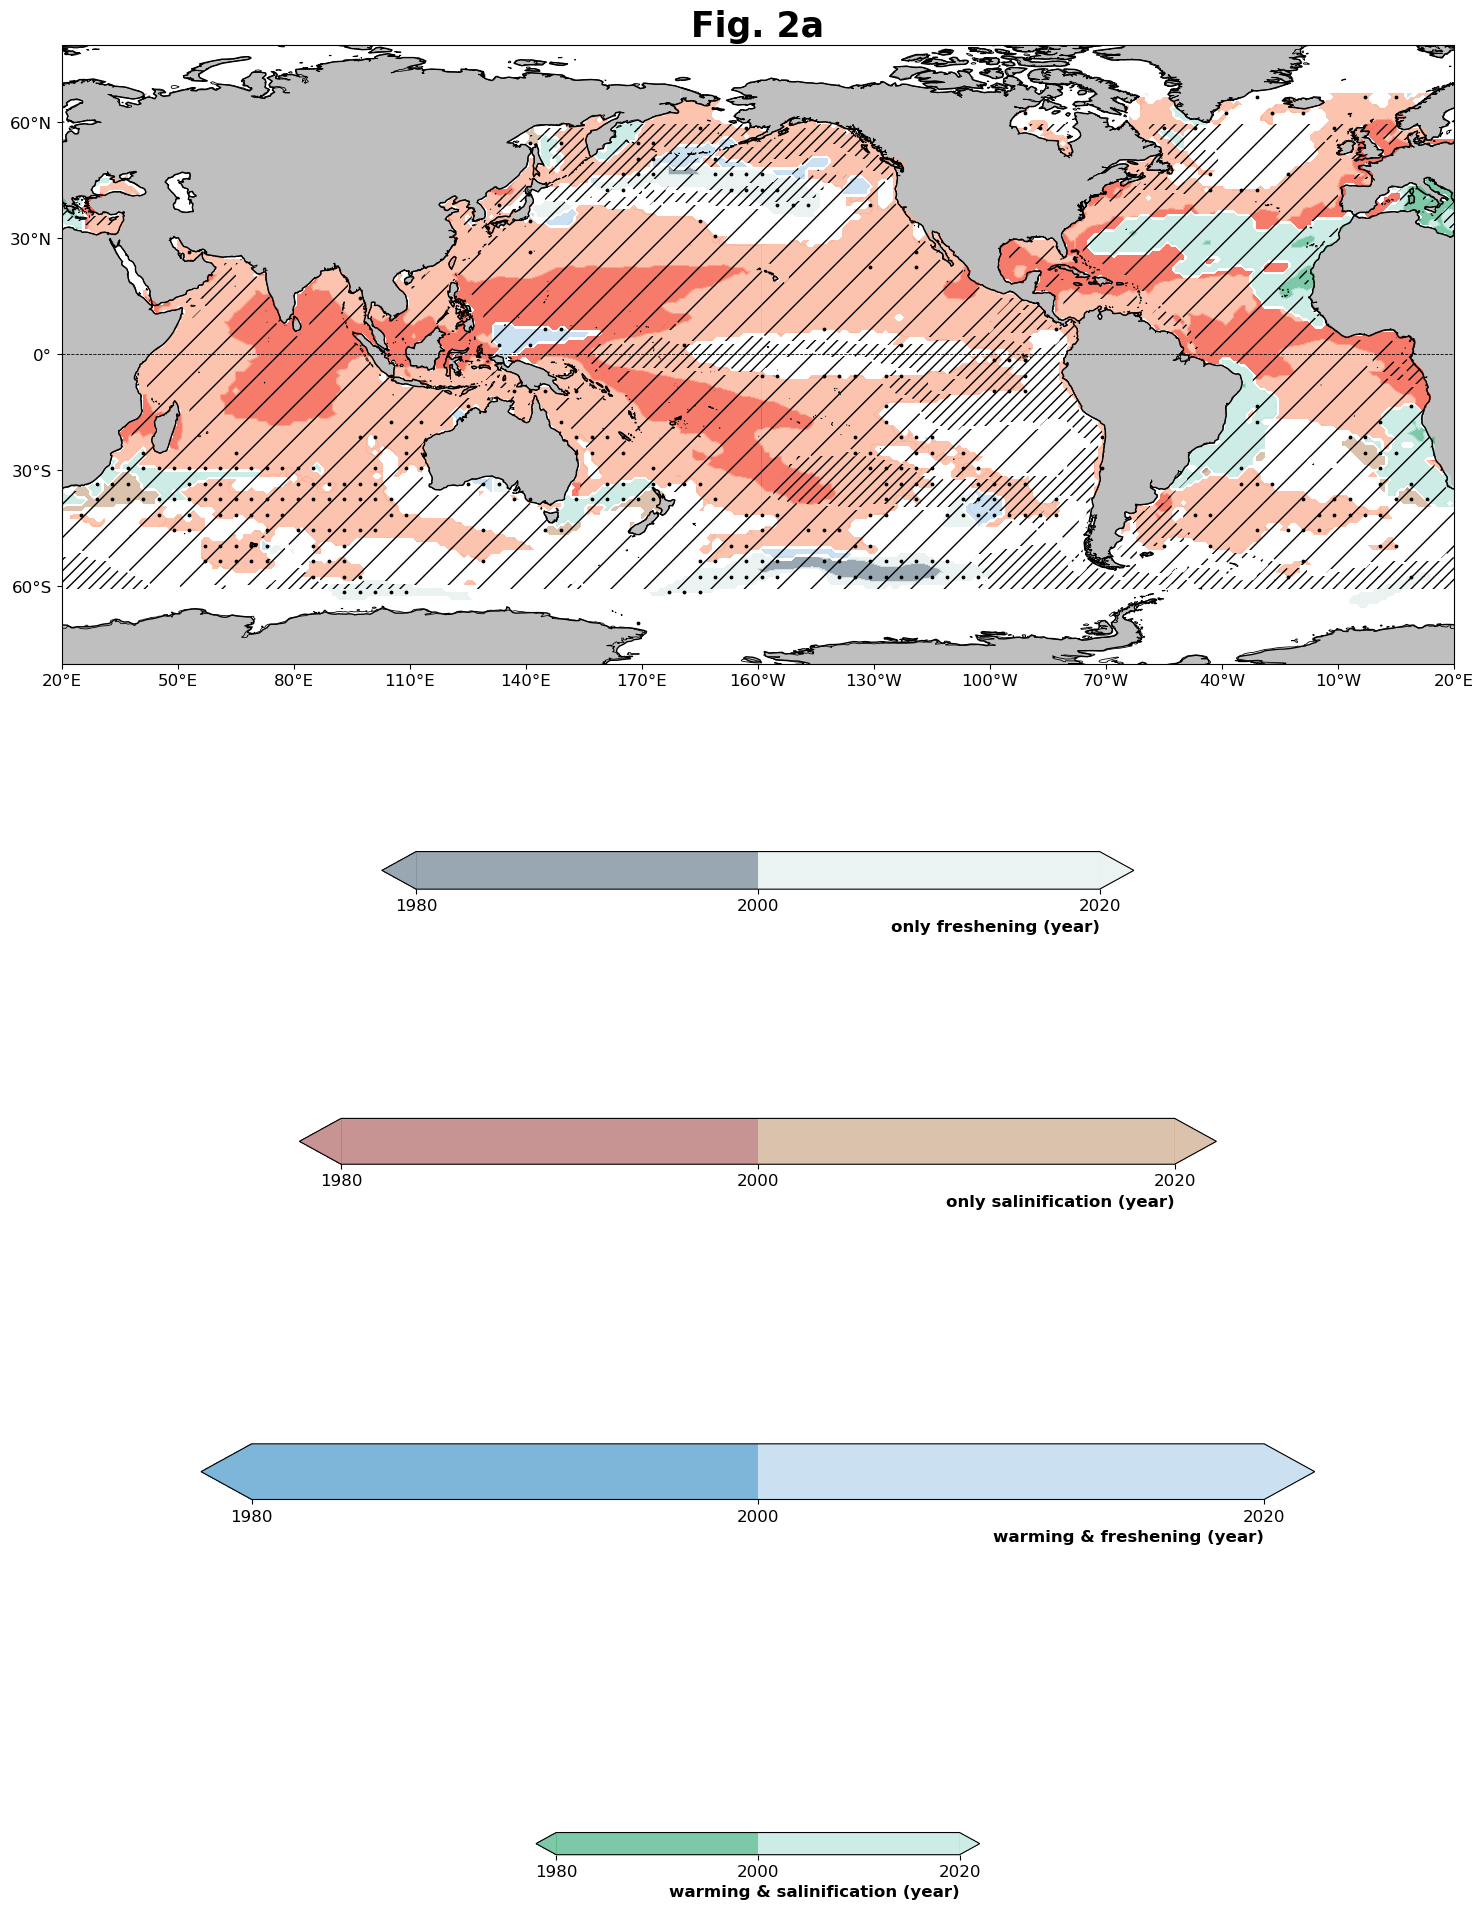

In [6]:
###### plot Fig.2a
lon2d,lat2d=np.meshgrid(cycle_lon,lat)

fig=plt.figure(figsize=(15, 23))
# plt.rcParams['font.family'] = 'Arial'  # Font type
plt.rcParams['font.size'] = '12' 
box=[-180,180,-90,90]  
scale='50m'
xstep,ystep=30,30
proj=ccrs.PlateCarree(central_longitude=200)
ax2=plt.axes(projection=proj)   #create map and projection
ax2.plot([-180,180],[0,0],'--',linewidth=0.6,transform=proj,color='black')
ax2.add_feature(cfeature.LAND, facecolor='0.75') #fill land color
ax2.add_feature(cfeature.COASTLINE, facecolor='0.75')
ax2.coastlines(scale,linewidth=0.6)  # coastlines
ax2.set_xticks(np.arange(box[0], box[1] + xstep, xstep), crs=proj)
ax2.set_yticks(np.arange(box[2], box[3] + ystep, xstep), crs=proj)
lon_formatter = LongitudeFormatter(zero_direction_label=False) 
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter) 
ax2.yaxis.set_major_formatter(lat_formatter)  
ax2.set_extent([-180,180,-80,80],crs=proj)

#### plot contour lines
interval=np.arange(1980,2022,20)
cb1=ax2.contourf(lon2d,lat2d,(ToE_onlyWarming),interval,cmap=new_reds,alpha=0.75,extend='both',transform=proj)
cb2=ax2.contourf(lon2d,lat2d,(TOE_overlap_warming_salinification),interval,cmap=new_greens,alpha=0.75,extend='both',transform=proj)   #transform是固定的，用于把数据转换到cartopy中
cb3=ax2.contourf(lon2d,lat2d,(TOE_overlap_warming_freshening),interval,cmap=new_blues,alpha=0.75,extend='both',transform=proj)   #transform是固定的，用于把数据转换到cartopy中
cb4=ax2.contourf(lon2d,lat2d,(ToE_onlySalin),interval,cmap=new_pinks,alpha=0.80,extend='both',transform=proj)   
cb5=ax2.contourf(lon2d,lat2d,(ToE_onlyFresh),interval,cmap=new_bones,alpha=0.80,extend='both',transform=proj)  

ToE_acidification_surface_before1995=np.copy(ToE_acidification_surface)  ###### divide before & after 1995 for pH data
ToE_acidification_surface_before1995[np.where(ToE_acidification_surface>=1995)]=np.nan
ToE_acidification_surface_after1995=np.copy(ToE_acidification_surface)
ToE_acidification_surface_after1995[np.where(ToE_acidification_surface<1995)]=np.nan

cb1_1=ax2.contourf(lon2d,lat2d,(ToE_acidification_surface_before1995),(1989,1995),hatches=['/'],linewidth=0.4,cmap=new_whites,alpha=0,transform=proj)
cb1_2=ax2.contourf(lon2d,lat2d,(ToE_acidification_surface_after1995),(1995,2000,2005,2010,2015,2022),hatches=['///'],linewidth=1,alpha=0,cmap=new_whites,transform=proj)

## putting insignificant dots
ToE_warming_freshening_significant_flag=reduced_dimension(ToE_warming_freshening_significant_flag)
row, col = np.where(ToE_warming_freshening_significant_flag == 0)  #insignificant points
lons=lon[row]
lats=lat[col]
cb8=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_warming_salinification_significant_flag=reduced_dimension(ToE_warming_salinification_significant_flag)
row, col = np.where(ToE_warming_salinification_significant_flag == 0)  #insignificant points
lons=lon[row]
lats=lat[col]
cb9=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_onlyWarming_significant_surface=reduced_dimension(ToE_onlyWarming_significant_surface,4)
row, col = np.where(ToE_onlyWarming_significant_surface == 0) 
lons=lon[row]
lats=lat[col]
cb13=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_onlySalin_significant_surface=reduced_dimension(ToE_onlySalin_significant_surface,4)
row, col = np.where(ToE_onlySalin_significant_surface == 0) 
lons=lon[row]
lats=lat[col]
cb17=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

ToE_onlyFresh_significant_surface=reduced_dimension(ToE_onlyFresh_significant_surface,4)
row, col = np.where(ToE_onlyFresh_significant_surface == 0) 
lons=lon[row]
lats=lat[col]
cb18=ax2.scatter(lons, lats, transform=proj, s=3, color='black')

#### set colorbar
cbar2=fig.colorbar(cb2,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.01)
cbar3=fig.colorbar(cb3,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)
cbar4=fig.colorbar(cb4,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)
cbar5=fig.colorbar(cb5,ax=ax2,orientation='horizontal',shrink=0.8,fraction=0.03)

cbar2.set_label('warming & salinification (year)', size=12, fontweight='bold', color='k',loc='right')
cbar3.set_label('warming & freshening (year)', size=12, fontweight='bold', color='k',loc='right')
cbar4.set_label('only salinification (year)', size=12, fontweight='bold', color='k',loc='right')
cbar5.set_label('only freshening (year)', size=12, fontweight='bold', color='k',loc='right')
plt.title('Fig. 2a',fontdict={'weight':'bold','size':25})
fig.tight_layout()

plt.savefig('./Fig2a.pdf', dpi=750, bbox_inches='tight')
plt.show()